In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import matplotlib as mpl

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
read_lens = od+expand(config['lr']['read_len_meta'], species='human')[0]
introp_bed = od+expand(config['intropolis']['bed'], species='human')[0]

gene_subset = 'polya'
ref_sources = ['v29', 'v40']
min_tpm = 1

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_read_lens = od+expand(config['lr']['read_len_meta'], species='mouse')[0]
m_ref_sources = ['vM21', 'vM25']

## How well supported are splice junctions? 

In [6]:
ca = cerberus.read(cerberus_h5)

In [12]:
sj_df, sj_ic_df = get_sj_from_ic(ca.ic, ref_sources)

In [15]:
# read intropolis 
i_df = pr.read_bed(introp_bed).df
source = 'intropolis'
i_df['source'] = source
i_df = i_df.loc[i_df.Start.notnull()]
i_df[source] = True

keep_cols = ['Chromosome', 'Start', 'End', 'Strand', 'intropolis']
i_df = i_df[keep_cols].drop_duplicates()

In [16]:
# merge in
df = sj_df.merge(i_df[keep_cols],
                how='left',
                on=['Chromosome', 'Start', 'End', 'Strand'])
df[source] = df[source].fillna(False)
df[['Start', 'intropolis']].groupby('intropolis').count()

,Start
intropolis,
False,29712
True,423356


In [17]:
df[['novelty', 'intropolis', 'Start']].groupby(['novelty', 'intropolis']).count()

Start
novelty intropolis        
Known   False        24897
        True        383883
Novel   False         4815
        True         39473

## Determine % of splice junctions supported per IC


In [18]:
keep_cols = ['Chromosome', 'Strand', 'Start', 'End', 'intropolis']
temp = sj_ic_df.merge(df[keep_cols], 
                    how='left',
                    on=['Chromosome', 'Start', 'End', 'Strand'])

In [20]:
# how many sjs / intron chain
temp2 = temp[['Name', 'Start']].groupby(['Name']).count().reset_index().rename({'Start':'n_sjs'}, axis=1)

In [21]:
# how many intropolis supported sjs / intron chain
temp3 = temp.loc[temp.intropolis == True]
temp3 = temp3[['Name', 'intropolis']].groupby(['Name']).count().reset_index().rename({'intropolis':'n_sjs_supported'}, axis=1)

In [22]:
ic = ca.ic.copy(deep=True)
ic = ic.merge(temp2, how='left', on='Name')
ic = ic.merge(temp3, how='left', on='Name')

In [27]:
ic['perc_supported'] = (ic['n_sjs_supported']/ic['n_sjs'])*100

In [28]:
# what does % sj support by intropolis look like for 
# detected ics by novelty category
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df, ic_ids = get_tpm_table(ab_df,
               how='ic',
               gene_subset=gene_subset,
               min_tpm=min_tpm)

Calculating ic TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # ics detected: 145107
# ics >= 1 tpm: 131129
Applying gene type and novelty subset
Number of ics reported: 127879


In [29]:
# percent of ics w/ 100% support per novelty category
ic['fully_supported'] = False
ic.loc[ic.perc_supported==100, 'fully_supported'] = True
ic.tail()

,Chromosome,Strand,Coordinates,Name,source,novelty,gene_id,ic,n_sjs,n_sjs_supported,fully_supported,perc_supported
356441,chrY,-,19744670-19744553-19744384-19743239-19743161-1...,ENSG00000012817_12,gtex,NIC,ENSG00000012817,12,25.0,25.0,True,100.0
356442,chrY,-,19744670-19744553-19744384-19743239-19743161-1...,ENSG00000012817_13,gtex,NIC,ENSG00000012817,13,24.0,24.0,True,100.0
356443,chrY,-,19744670-19744553-19744384-19743239-19743161-1...,ENSG00000012817_14,gtex,ISM,ENSG00000012817,14,16.0,16.0,True,100.0
356444,chrY,-,19744670-19744553-19744384-19743239-19743161-1...,ENSG00000012817_15,gtex,NIC,ENSG00000012817,15,25.0,25.0,True,100.0
356445,chrY,-,19744670-19744553-19744384-19743239-19743161-1...,ENSG00000012817_16,gtex,NIC,ENSG00000012817,16,26.0,26.0,True,100.0


In [30]:
temp = ic[['fully_supported', 'novelty', 'Name']].groupby(['fully_supported', 'novelty']).count().reset_index().rename({'Name': 'n_ic'}, axis=1)
temp2 = ic[['Name', 'novelty']].groupby('novelty').count().reset_index().rename({'Name':'n_total_ic'}, axis=1)

In [31]:
# only fully supported
temp = temp.loc[temp.fully_supported==True]
temp = temp.merge(temp2, how='left', on='novelty')
temp['perc_fully_supported'] = (temp.n_ic/temp.n_total_ic)*100
temp

,fully_supported,novelty,n_ic,n_total_ic,perc_fully_supported
0,True,ISM,15051,15230,98.824688
1,True,Known,205944,250272,82.288071
2,True,NIC,67835,72470,93.604250
3,True,NNC,14883,16895,88.091151


<AxesSubplot:xlabel='novelty', ylabel='perc_fully_supported'>

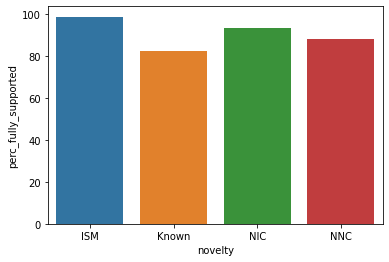

In [32]:
sns.barplot(temp, x='novelty', y='perc_fully_supported')

## What % of novel splice junctions from detected ics that we call are supported by intropolis?

In [33]:
det_sjs = sj_ic_df.loc[sj_ic_df.Name.isin(ic_ids)]

# whether these sjs were detected in intropolis
print(len(det_sjs))
det_sjs = det_sjs.merge(df[['gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'intropolis']], 
                               on=['gene_id', 'Chromosome', 'Start', 'End', 'Strand'],
                               how='left')
print(len(det_sjs))

955591
955591


<AxesSubplot:xlabel='novelty', ylabel='count'>

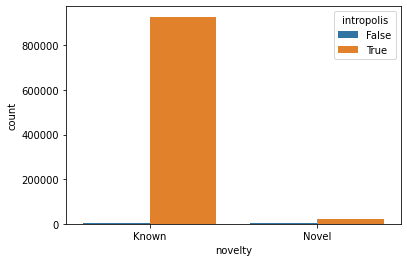

In [34]:
temp = det_sjs[['intropolis', 'novelty', 'Start']].groupby(['intropolis', 'novelty']).count().reset_index().rename({'Start':'count'}, axis=1)
sns.barplot(data=temp, 
            x='novelty',
            hue='intropolis',
            y='count')

## What % of novel SJs are supported by intropolis?

In [7]:
sj_df, sj_ic_df = get_sj_from_ic(ca.ic, ref_sources)

In [8]:
ca.ic.head()

,Chromosome,Strand,Coordinates,Name,source,novelty,gene_id,ic
0,chr1,+,-,ENSG00000004487_18,"v40,v29,lapa",Known,ENSG00000004487,18
1,chr1,+,-,ENSG00000033122_5,"v40,v29,lapa",Known,ENSG00000033122,5
2,chr1,+,-,ENSG00000049246_6,"v40,v29,lapa",Known,ENSG00000049246,6
3,chr1,+,-,ENSG00000077157_8,"v40,v29,lapa",Known,ENSG00000077157,8
4,chr1,+,-,ENSG00000099260_3,"v40,v29,lapa",Known,ENSG00000099260,3


In [9]:
# read intropolis 
i_df = pr.read_bed(introp_bed).df
source = 'intropolis'
i_df['source'] = source
i_df = i_df.loc[i_df.Start.notnull()]
i_df[source] = True

keep_cols = ['Chromosome', 'Start', 'End', 'Strand', 'intropolis']
i_df = i_df[keep_cols].drop_duplicates()

In [10]:
# merge in
df = sj_df.merge(i_df[keep_cols],
                how='left',
                on=['Chromosome', 'Start', 'End', 'Strand'])
df[source] = df[source].fillna(False)

,Start
intropolis,
False,29598
True,423356


In [15]:
df.head()
df['sj'] = df.Chromosome+df.Strand+df.Start.astype(str)+df.End.astype(str)
df = df[['novelty','intropolis','sj']].groupby(['novelty', 'intropolis']).count()
df = df.reset_index()

In [29]:
df.head()
temp = df[['novelty', 'sj']].groupby('novelty').sum().reset_index()
temp.rename({'sj': 'total'}, axis=1, inplace=True)
df = df.merge(temp, on='novelty', how='left')
df['perc'] = (df['sj']/df['total'])*100
df

,novelty,intropolis,sj,total_x,total_y,total_x,total_y,total,perc
0,Known,False,24783,408666,408666,408666,408666,408666,6.064366
1,Known,True,383883,408666,408666,408666,408666,408666,93.935634
2,Novel,False,4815,44288,44288,44288,44288,44288,10.872020
3,Novel,True,39473,44288,44288,44288,44288,44288,89.127980


<AxesSubplot:xlabel='novelty', ylabel='sj'>

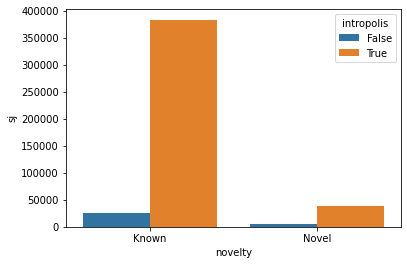

In [30]:
df
sns.barplot(df, x='novelty', y='sj', hue='intropolis')

<AxesSubplot:xlabel='novelty', ylabel='perc'>

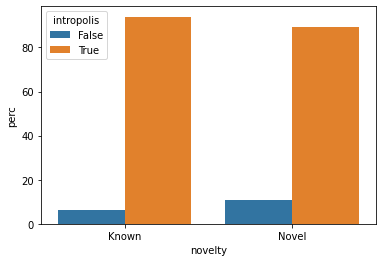

In [31]:
df
sns.barplot(df, x='novelty', y='perc', hue='intropolis')